### LC50 analysis

- Handle warning

In [1]:
import warnings
warnings.filterwarnings('ignore')

- Load modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns

- Auxiliar functions

In [3]:
def LL4(x, b, c, d, e):
    """
    LL.4 (Log-logistic, 4 parámetros):
    b = pendiente (Hill slope)
    c = mínimo (bottom)
    d = máximo (top)
    e = LC50
    """
    return c + (d - c) / (1 + np.exp(b * (np.log(x) - np.log(e))))


- Load data

In [4]:
data = pd.read_csv("../raw_data/lc50_data.csv")
data

,Salinity,Replica1,Replica2,Replica3
0,34.0,0,0,0
1,36.4,0,0,10
2,45.8,0,0,10
3,51.8,10,20,10
4,57.7,100,100,100
5,58.0,100,100,100
6,58.8,100,100,100
7,59.4,100,100,100


- Prepare data and fit model

In [5]:
data["response"] = data[["Replica1", "Replica2", "Replica3"]].mean(axis=1)

In [6]:
xdata = data["Salinity"].values
ydata = data["response"].values
p0 = [1, 0, 100, 50]  # valores iniciales para ajuste

popt, _ = curve_fit(LL4, xdata, ydata, p0=p0)

b, c, d, e = popt
LC50 = e
LC50_response = LL4(LC50, *popt)

- Get curve prediction

In [7]:
x_fit = np.linspace(min(xdata), max(xdata), 200)
y_fit = LL4(x_fit, *popt)
df_curve = pd.DataFrame({"Salinity": x_fit, "Predicted": y_fit})

- Generate plot

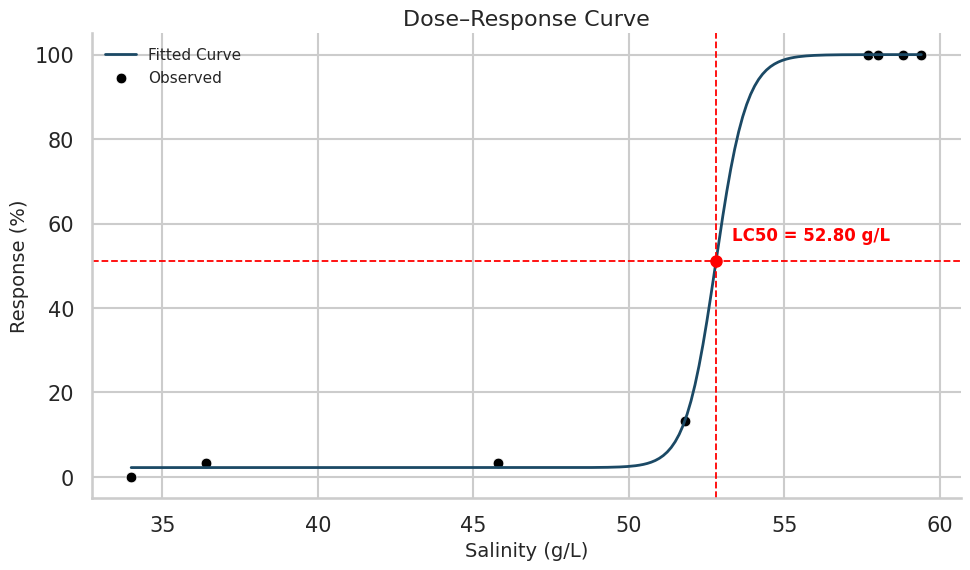

In [8]:
sns.set(style="whitegrid", context="talk", font_scale=0.91)
plt.figure(figsize=(10, 6))

ax = sns.lineplot(
    data=df_curve,
    x="Salinity",
    y="Predicted",
    color="#1b4965",
    linewidth=2,
    label="Fitted Curve"
)

sns.scatterplot(
    data=data,
    x="Salinity",
    y="response",
    color="black",
    s=60,
    edgecolor="white",
    label="Observed"
)

ax.axvline(LC50, linestyle="--", color="red", linewidth=1.3)
ax.axhline(LC50_response, linestyle="--", color="red", linewidth=1.3)
ax.plot(LC50, LC50_response, 'o', color="red", markersize=8)
ax.text(LC50 + 0.5, LC50_response + 5, f"LC50 = {LC50:.2f} g/L",
        color="red", fontsize=12, weight='bold')

ax.set_xlabel("Salinity (g/L)", fontsize=14)
ax.set_ylabel("Response (%)", fontsize=14)
ax.set_title("Dose–Response Curve", fontsize=16)
ax.legend(title=None, fontsize=11, loc='best', frameon=False)

sns.despine()
plt.tight_layout()
plt.savefig("../figures_paper/lc50.png", dpi=300)
plt.show()

In [14]:
df_curve.to_csv("../data_for_plots/data_lc50/df_curve_lc50.csv", index=False)
data.to_csv("../data_for_plots/data_lc50/data_lc50.csv", index=False)

In [15]:
dict_data = {
    "LC50": float(LC50),
    "LC50_response": float(LC50_response)
}

from json import dump

with open("../data_for_plots/data_lc50/data_config.json", 'w+') as doc:
    dump(dict_data, doc, indent=2)